In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.layers import Lambda

In [3]:
! unzip ./gdrive/My\ Drive/data.zip

Archive:  ./gdrive/My Drive/data.zip
  inflating: X_train_valid.npy       
   creating: __MACOSX/
  inflating: __MACOSX/._X_train_valid.npy  
  inflating: person_train_valid.npy  
  inflating: __MACOSX/._person_train_valid.npy  
  inflating: y_train_valid.npy       
  inflating: __MACOSX/._y_train_valid.npy  
  inflating: y_test.npy              
  inflating: __MACOSX/._y_test.npy   
  inflating: X_test.npy              
  inflating: __MACOSX/._X_test.npy   
  inflating: person_test.npy         
  inflating: __MACOSX/._person_test.npy  


In [0]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

person_train_valid = np.load("person_train_valid.npy")
person_test = np.load("person_test.npy")


In [0]:
X_train_valid = X_train_valid[:, :-3, :]
X_test = X_test[:, :-3, :]

X_train_valid = np.expand_dims(X_train_valid, 3)
X_test = np.expand_dims(X_test, 3)

person_train_valid = np.squeeze(person_train_valid)
person_test = np.squeeze(person_test)

y_train_valid -= 769
y_test -= 769


In [6]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))

print ('Test data shape: {}'.format(X_test.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000, 1)
Test target shape: (443,)
Person test shape: (443,)


In [0]:
class Attention(tf.keras.Model):
    def __init__(self, h_dim):
        super(Attention, self).__init__(name='')

        self.a1 = AttentionBlock(h_dim)
        self.a2 = AttentionBlock(h_dim)

    def call(self, input, training=False):
        
        f, b = tf.split(input, 2, -1)
        
        f = self.a1(f)
        b = self.a2(b)
        
        return tf.concat([f, b], -1)
    
###############################################################################
class AttentionBlock(tf.keras.Model):
    def __init__(self, h_dim):
        super(AttentionBlock, self).__init__(name='')

        self.dense1 = layers.Dense(h_dim)
        self.bn1 = layers.BatchNormalization()
        #self.relu = layers.LeakyReLU()
        self.relu = layers.ELU()
    
    
        self.dense2 = layers.Dense(1)
        #self.bn2 = layers.BatchNormalization()
        
        #self.dense3 = layers.Dense(1)
        
        self.sm = layers.Softmax()
        
        self.d = layers.Dot(0)
    

    def call(self, input, training=False):
        x = self.dense1(input)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.dense2(x)
        #x = self.bn2(x, training=training)
        #x = self.relu(x)
        #print(x.get_shape().as_list())
        
        #x = self.dense3(x)
        
        x = tf.squeeze(x, -1)
        x = self.sm(x)

        return self.d([input, x])

In [0]:

###############################################################################
def create_model(n_filters=64, n_neurons=256, drops=[0.25,0.25,0.25], lr=1e-4, subject=False):
    
    # drops[0]: conv drop
    # drops[1]: GRU drop
    # drops[2]: GRU recurrent drop
    
    
    inputs = layers.Input(X_train_valid[0].shape)
    
    # conv
    x = layers.Conv2D(n_filters, (1,5), (1,5), 'valid')(inputs)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, (22, 1), (1,1), 'valid')(x)
    x = layers.ELU()(x)
    #x = layers.MaxPool2D((1,4), (1,1))(x)
    x = layers.AveragePooling2D((1,4), (1,1))(x)
    x = layers.Dropout(drops[0])(x)
    
    # reshape
    x = layers.Permute((3,2,1))(x)
    #x = layers.Permute((2,3,1))(x)
    
    def remove_axis(x):
        return backend.squeeze(x, -1)
        #eturn backend.squeeze(x)
    
    x = Lambda(remove_axis)(x)
      
    # GRU
    x = layers.Bidirectional(layers.GRU(n_neurons, 
                                        dropout=drops[1], 
                                        recurrent_dropout=drops[2], 
                                        return_sequences=True), merge_mode='concat')(x)
    
    

    #x = AttentionBlock(20)(x)
    x = Attention(16)(x)
    
    if subject:
        predictions = layers.Dense(9, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    else:
        predictions = layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
    
    
    
    
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
    #model.summary()
    
    # compile
    model.compile(optimizer=tf.train.AdamOptimizer(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [31]:
model_sig = create_model(n_filters=64, n_neurons=64, drops=[0.1, 0.1, 0.1], lr=1e-4)

history_sig = model_sig.fit(X_train_valid, y_train_valid, validation_data=(X_test, y_test), epochs=200, batch_size=256, verbose=1)

#model.evaluate(X_test, y_test)

[None, 64, 64]
Train on 2115 samples, validate on 443 samples
Epoch 1/200
2115/2115 [==============================] - 8s 4ms/sample - loss: 1.4685 - acc: 0.2463 - val_loss: 1.4676 - val_acc: 0.2777
Epoch 2/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4559 - acc: 0.2775 - val_loss: 1.4601 - val_acc: 0.2641
Epoch 3/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4523 - acc: 0.2851 - val_loss: 1.4527 - val_acc: 0.2844
Epoch 4/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4431 - acc: 0.3168 - val_loss: 1.4480 - val_acc: 0.2844
Epoch 5/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4349 - acc: 0.3177 - val_loss: 1.4435 - val_acc: 0.2912
Epoch 6/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4270 - acc: 0.3390 - val_loss: 1.4365 - val_acc: 0.3115
Epoch 7/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 1.4176 - acc: 0.3456 - val_loss: 1.42

In [33]:
model_subject = create_model(n_filters=64, n_neurons=64, drops=[0.1, 0.1, 0.1], lr=1e-4, subject=True)

history_subject = model_subject.fit(X_train_valid, person_train_valid, validation_data=(X_test, person_test), epochs=200, batch_size=256, verbose=1)

[None, 64, 64]
Train on 2115 samples, validate on 443 samples
Epoch 1/200
2115/2115 [==============================] - 6s 3ms/sample - loss: 2.4149 - acc: 0.1002 - val_loss: 2.3780 - val_acc: 0.1084
Epoch 2/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3721 - acc: 0.1130 - val_loss: 2.3626 - val_acc: 0.1084
Epoch 3/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3531 - acc: 0.1182 - val_loss: 2.3479 - val_acc: 0.1400
Epoch 4/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3465 - acc: 0.1470 - val_loss: 2.3356 - val_acc: 0.1558
Epoch 5/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3309 - acc: 0.1485 - val_loss: 2.3203 - val_acc: 0.1535
Epoch 6/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3163 - acc: 0.1740 - val_loss: 2.3039 - val_acc: 0.1467
Epoch 7/200
2115/2115 [==============================] - 4s 2ms/sample - loss: 2.3010 - acc: 0.1754 - val_loss: 2.28

In [0]:
def plot_train(history):
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history['loss'], label='train_loss')
    ax1.plot(history['val_loss'], label='val_loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoches')
    ax1.legend()
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history['acc'], label='train_acc')
    ax2.plot(history['val_acc'], label='val_acc')
    ax2.set_ylabel('acc')
    ax2.set_xlabel('epoches')
    ax2.legend()

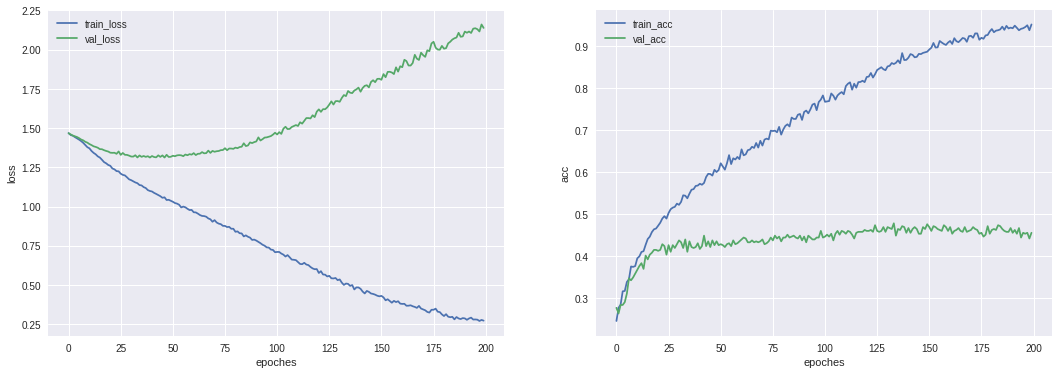

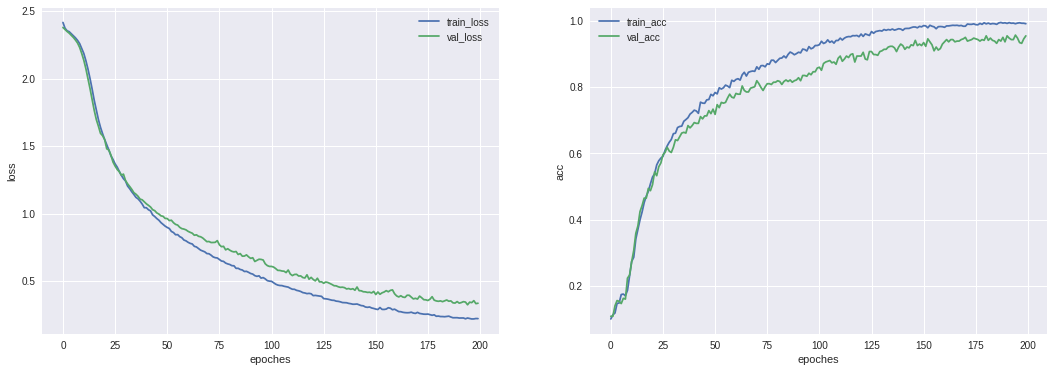

In [35]:
plot_train(history_sig.history)
plot_train(history_subject.history)

In [0]:
def accuracy_over_time(model, X_test, y_test, period=100):
    
    X = X_test.copy()
    
    n = 1000 // period
    acc = [0]*n
    
    for i in range(n):
        if i != 0:
            X[:,:,-period*i:] = 0
            
        acc[i] = np.sum(np.argmax(model.predict(X), axis=1) == y_test) / len(y_test)
  
    acc = acc[::-1]
    max_acc = max(acc)
    max_acc_idx = acc.index(max_acc)
    best_seq_len = max_acc_idx*period
    print(f'max acc: {max_acc:.3f} with sequence length: {best_seq_len}')
    
    
    x = list(range(0, 1000, period))
  
    plt.plot(x, acc)
    plt.axvline(best_seq_len, color='c', linestyle='--')
    plt.axhline(max_acc, color='c', linestyle='--')
    plt.xlabel('sequence length')
    plt.ylabel('acc')

max acc: 0.470 with sequence length: 700


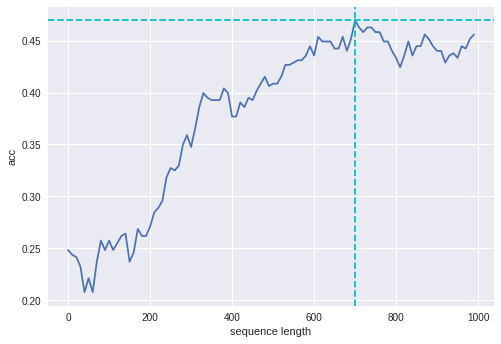

In [37]:
accuracy_over_time(model_sig, X_test, y_test, 10)

max acc: 0.955 with sequence length: 990


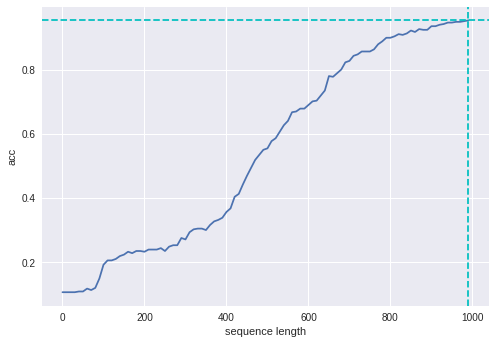

In [38]:
accuracy_over_time(model_subject, X_test, person_test, 10)

In [39]:
from sklearn.metrics import f1_score

y_pred_sig = np.argmax(model_sig.predict(X_test), 1)
print('F1 of signal classification: ')
print(f1_score(y_test, y_pred_sig, average=None))

y_pred_sub = np.argmax(model_subject.predict(X_test), 1)
print('F1 of signal classification: ')
print(f1_score(person_test, y_pred_sub, average=None))

F1 of signal classification: 
[0.44843049 0.43776824 0.44       0.49565217]
F1 of signal classification: 
[0.91262136 0.94117647 0.95833333 0.98989899 0.97826087 0.92929293
 0.98989899 0.91089109 0.98947368]
